## Exploratory Data Analysis for shelter data

In [1]:
//load required libraries

import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.Dataset
import org.apache.spark.sql.functions.udf
import scala.math.BigDecimal
import java.util.Calendar
import java.io
import java.text.SimpleDateFormat
import org.apache.spark.sql.SparkSession
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.SparkContext
import org.apache.spark.SparkConf
import org.apache.spark.ml.clustering.LDA
import org.apache.spark.ml.linalg.{Vector, Vectors}
import org.apache.spark.ml.stat.ChiSquareTest
import org.apache.spark.ml.feature.VectorIndexer
import org.apache.spark.mllib.linalg.{VectorUDT, Vectors}
import org.apache.spark.sql.{Row, SQLContext}
import org.apache.spark.sql.types.{StructField, StructType}
import org.apache.spark.sql.SparkSession
import org.apache.spark.ml.feature.{OneHotEncoderEstimator, StringIndexer, StringIndexerModel}
import org.apache.spark.ml.{Pipeline, PipelineModel}
import spark.implicits._
import org.apache.spark.mllib.stat.{Statistics => OldStatistics}
import org.apache.spark.ml.stat.ChiSquareTest
import org.apache.spark.mllib.linalg._
import org.apache.spark.mllib.stat.Statistics
import org.apache.spark.rdd.RDD

Intitializing Scala interpreter ...

Spark Web UI available at http://990ab9a36641:4041
SparkContext available as 'sc' (version = 2.4.3, master = local[*], app id = local-1560058329379)
SparkSession available as 'spark'


2019-06-09 05:32:07,677 WARN  [main] util.NativeCodeLoader (NativeCodeLoader.java:<clinit>(62)) - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2019-06-09 05:32:09,166 WARN  [Thread-4] util.Utils (Logging.scala:logWarning(66)) - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.Dataset
import org.apache.spark.sql.functions.udf
import scala.math.BigDecimal
import java.util.Calendar
import java.io
import java.text.SimpleDateFormat
import org.apache.spark.sql.SparkSession
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.SparkContext
import org.apache.spark.SparkConf
import org.apache.spark.ml.clustering.LDA
import org.apache.spark.ml.linalg.{Vector, Vectors}
import org.apache.spark.ml.stat.ChiSquareTest
import org.apache.spark.ml.feature.VectorIndexer
import org.apache.spark.mllib.linalg.{VectorUDT, Vectors}
import org.apache.spark.sql.{Row, SQLContext}
import org.apache.spark.sql.types.{StructField, StructType}
import org.apache.spark.sql.SparkSession
import org.apache.spar...

In [2]:
//read data from Phase 2 wrangling task.
//name the columns required for EDA
var dataFPN = "phase2_output"
val phase2 = spark.read.format("csv").load(dataFPN)

val colnames = Array("id_in","name_in","location_found_in","intake_type","intake_condition","species_in","age_years_in",
                     "sex_in","desexed_in","prim_colour_in","sec_colour_in","mix_breed_bool_in","prim_breed_in","date_in",
                     "time_in","ampm_in","month_in","weekday_in","dob_in","outcome_type","outcome_subtype","age_years_out",
                     "desexed_out","date_out","time_out","ampm_out","month_out","weekday_out")

val animal_df = phase2.toDF(colnames: _*)


dataFPN: String = phase2_output1
phase2: org.apache.spark.sql.DataFrame = [_c0: string, _c1: string ... 26 more fields]
colnames: Array[String] = Array(id_in, name_in, location_found_in, intake_type, intake_condition, species_in, age_years_in, sex_in, desexed_in, prim_colour_in, sec_colour_in, mix_breed_bool_in, prim_breed_in, date_in, time_in, ampm_in, month_in, weekday_in, dob_in, outcome_type, outcome_subtype, age_years_out, desexed_out, date_out, time_out, ampm_out, month_out, weekday_out)
animal_df: org.apache.spark.sql.DataFrame = [id_in: string, name_in: string ... 26 more fields]


### Check the types of animals being brought to the shelter and why:

In [3]:
val antype = animal_df.
  groupBy('species_in).
  agg(count('id_in) as "count").
  orderBy(desc("count"))
antype.show()

2019-06-09 05:33:30,395 WARN  [Thread-4] util.Utils (Logging.scala:logWarning(66)) - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
+----------+-----+
|species_in|count|
+----------+-----+
|       Dog|56954|
|       Cat|36476|
|     Other| 5317|
|      Bird|  462|
| Livestock|   15|
+----------+-----+



antype: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [species_in: string, count: bigint]


In [4]:
val intake = animal_df.
  groupBy('intake_type).
  agg(count('id_in) as "count").
  orderBy(desc("count"))
intake.show()

+------------------+-----+
|       intake_type|count|
+------------------+-----+
|             Stray|69844|
|   Owner Surrender|18828|
|     Public Assist| 6249|
|          Wildlife| 4048|
|Euthanasia Request|  255|
+------------------+-----+



intake: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [intake_type: string, count: bigint]


### What outcomes are we aiming to predict:

In [5]:
val outcome = animal_df.
  groupBy('outcome_type).
  agg(count('id_in) as "count").
  orderBy(desc("count"))
outcome.show()

+---------------+-----+
|   outcome_type|count|
+---------------+-----+
|       Adoption|42760|
|       Transfer|29415|
|Return to Owner|18226|
|     Euthanasia| 7104|
|           Died|  892|
|      Rto-Adopt|  388|
|       Disposal|  359|
|        Missing|   54|
|       Relocate|   18|
|        unknown|    8|
+---------------+-----+



outcome: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [outcome_type: string, count: bigint]


From here we allow Python magic cells to assist with scripting plots

In [8]:
//prepare the spark dataframe to be moved into a python dataframe
animal_df.createOrReplaceTempView("tempDataFrame")

In [9]:
%%python
# create python dataframe for eda
eda_df = spark.sql("select id_in, name_in, location_found_in, intake_type, intake_condition, species_in, age_years_in, sex_in, desexed_in, prim_colour_in, sec_colour_in, mix_breed_bool_in, prim_breed_in, date_in, time_in, ampm_in, month_in, weekday_in, dob_in, outcome_type, outcome_subtype, age_years_out, desexed_out, date_out, time_out, ampm_out, month_out, weekday_out from tempDataFrame").toPandas()

In [10]:
%%python

# some variables need to be converted as scala has loaded all as an object type by default
import pandas as pd
eda_df['date_in'] = pd.to_datetime(eda_df['date_in'])
eda_df['date_out'] = pd.to_datetime(eda_df['date_out'])
eda_df['dob_in'] = pd.to_datetime(eda_df['dob_in'])
eda_df['age_years_in'] = eda_df['age_years_in'].astype(str).astype(float)
eda_df['age_years_out'] = eda_df['age_years_out'].astype(str).astype(float)


In [11]:
%%python

# view datafrme
eda_df.head()

,id_in,name_in,location_found_in,intake_type,intake_condition,species_in,age_years_in,sex_in,desexed_in,prim_colour_in,sec_colour_in,mix_breed_bool_in,prim_breed_in,date_in,time_in,ampm_in,month_in,weekday_in,dob_in,outcome_type,outcome_subtype,age_years_out,desexed_out,date_out,time_out,ampm_out,month_out,weekday_out
0,A274546_1,Sophie,Manchaca And Slaughter in Austin (TX),Stray,Normal,Dog,11.0,female,true,tricolor,unknown,true,pointer,2013-11-13,06:16:00,AM,Nov,Wed,2002-05-25,Adoption,unknown,11.0,true,2013-11-16,12:24:00,PM,Nov,Sat
1,A298677_1,Polly,Manor (TX),Euthanasia Request,Sick,Dog,13.0,female,true,tan,unknown,true,german shepherd,2015-07-27,12:44:00,PM,Jul,Mon,2002-03-17,Euthanasia,Suffering,13.0,true,2015-07-27,01:59:00,AM,Jul,Mon
2,A443875_1,Sebastian,Austin (TX),Owner Surrender,Normal,Cat,13.0,male,true,gray,white,true,domestic shorthair,2019-04-07,01:10:00,AM,Apr,Sun,2006-03-21,Adoption,unknown,13.0,true,2019-04-16,04:03:00,AM,Apr,Tue
3,A455146_1,Ruby,Wagon Train Cv in Austin (TX),Stray,Normal,Dog,10.0,female,true,black,brown,true,rottweiler,2014-12-28,02:05:00,AM,Dec,Sun,2004-06-05,Transfer,Partner,10.0,true,2015-02-07,11:10:00,AM,Feb,Sat
4,A484080_1,Seven,7200 W. Easy Wind Dr. # 1079 in Austin (TX),Public Assist,Normal,Dog,11.0,female,true,gold,unknown,true,labrador retriever,2016-11-26,11:25:00,AM,Nov,Sat,2005-08-27,Return to Owner,unknown,11.0,true,2016-11-29,12:48:00,PM,Nov,Tue


In [12]:
%%python
#check the basic stats in the dataframe
eda_df.describe(include='all')

,id_in,name_in,location_found_in,intake_type,intake_condition,species_in,age_years_in,sex_in,desexed_in,prim_colour_in,sec_colour_in,mix_breed_bool_in,prim_breed_in,date_in,time_in,ampm_in,month_in,weekday_in,dob_in,outcome_type,outcome_subtype,age_years_out,desexed_out,date_out,time_out,ampm_out,month_out,weekday_out
count,99224,99224,99224,99224,99224,99224,99224.000000,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224,99224.000000,99224,99224,99224,99224,99224,99224
unique,99224,16734,44645,5,8,5,NaN,3,3,30,35,2,356,2057,720,2,12,7,6457,10,22,NaN,3,2057,720,2,12,7
top,A610808_1,unknown,Austin (TX),Stray,Normal,Dog,NaN,male,false,black,unknown,true,domestic shorthair,2014-07-09 00:00:00,11:01:00,AM,May,Mon,2015-09-01 00:00:00,Adoption,unknown,NaN,true,2016-07-09 00:00:00,12:00:00,AM,May,Sat
freq,1,30965,17994,69844,87409,56954,NaN,47441,61498,24988,32340,92421,29583,140,535,85326,10425,14998,118,42760,54312,NaN,66511,209,2594,87947,9300,15955
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,1991-12-11 00:00:00,NaN,NaN,NaN,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-19 00:00:00,NaN,NaN,NaN,NaN,2019-12-06 00:00:00,NaN,NaN,NaN,NaN,2019-05-19 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.096358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.133003,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,2.891902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.899889,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,NaN,NaN,NaN,NaN


This dataset runs from a period of October 2013 to May 2019. In order to explore the data by month and make inferences for this, the dataset needs consistent entries for each month. For this reason, the below monthly histograms will only include date from the years 2014 to 2018 to eliminate the incomplete years either side of the dataset.

In [14]:
%%python
# remove 2013 and 2019 data rows
eda_df_2014to2018 = eda_df[(eda_df['date_in'] >= '2014-01-01') & (eda_df['date_in'] < '2019-01-01')]

In [21]:
%%python
eda_df_2014to2018.groupby('month_out').count()[['id_in']].reset_index()

,month_out,id_in
0,Apr,6752
1,Aug,8458
2,Dec,6817
3,Feb,5775
4,Jan,6412
5,Jul,9075
6,Jun,8628
7,Mar,6812
8,May,8318
9,Nov,6803


In [15]:
%%python
# import libraries required for plotting
from matplotlib import pyplot as plt
from IPython.display import Image
import tempfile
import seaborn as sns

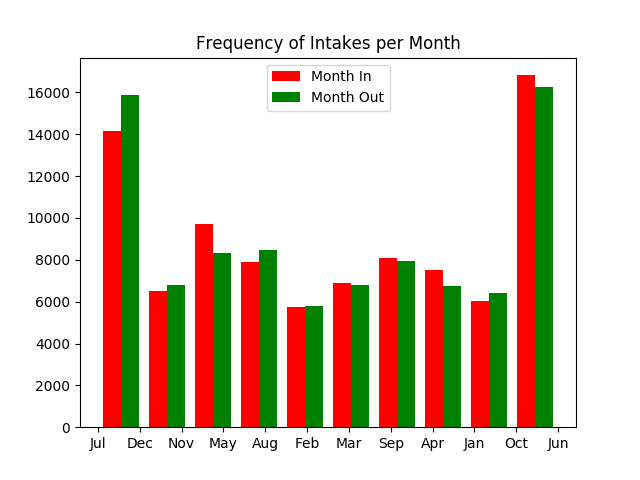

In [40]:
%%python

df_samp = eda_df_2014to2018.sample(n=1000)
month_order = ("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")

plt.clf()
plt.hist([eda_df_2014to2018['month_in'], eda_df_2014to2018['month_out']], color=['red', 'green'])
plt.xticks(month_order)
plt.title("Frequency of Intakes per Month")
plt.legend(["Month In", "Month Out"])
plt.show()
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Correllations

Getting a measure of the correllations between variables will help to choose the most effective variables for the machine learning phase.<br>
First, define some functions to assist with this:

In [ ]:
// 

def getColNames (dfSchema: Array[String],pattern: scala.util.matching.Regex): Array[String]={
    var colList = new Array[String](0)
    dfSchema.foreach({ 
        colName :String =>{
            colName match{
                
                case pattern() => colList = colList :+ colName
                case _ => 
            }
    }})
    return colList
} 

In [ ]:
def vectorize (df: DataFrame,colName: String):DataFrame={
    val encoder = new OneHotEncoderEstimator()
                            .setInputCols(Array(colName))
                            .setOutputCols(Array(colName+"_vector"))
                            .setDropLast(false)
    val in_vec  = encoder.fit(df).transform(df)
    return in_vec
}

In [ ]:
def indexing (df: DataFrame,colName: String):DataFrame={
    val indexer = new StringIndexer().setInputCol(colName).setOutputCol(s"indexed_$colName")
    val in_idx  = indexer.fit(df).transform(df)
    return in_idx.drop(colName)
}

In [ ]:
def encodingData(df: DataFrame, encodeType: String, skipCols: Array[String]): DataFrame ={
    var trans = df
    encodeType.toLowerCase match {
        case "index" => {
            df.schema.names.foreach({
                colName => {
                    if(!skipCols.contains(colName)){
                        trans = indexing(trans,colName)
                    }
                    trans = trans.drop(colName)
                }
            })
            return trans
        }
            
        case "vector"=>{
            df.schema.names.foreach({
                colName => {
                    if(!skipCols.contains(colName)){
                        trans = vectorize(trans,colName)
                    }
                    trans = trans.drop(colName)
                }
            })
            return trans
        }
        case _ => {
            println("Error in encodingData: 2nd Parameter is not a supported encoding method")
            return df
        }
    }
}

In [ ]:
def corrCal (index_in : DataFrame, index_out: DataFrame):DataFrame={
//    val outColNameRegx = "indexed_.*".r
//    val inColNameRegx  = "indexed_.*".r
    var outCols = index_out.schema.names
    var inCols  = index_in.schema.names
    val in_skip_cols = Array("indexed_id_in_vector","indexed_id_in")

    val crType = "pearson"

    
    var df = sc.parallelize(inCols).toDF("In_Schema")
    df.show()
    outCols.foreach(outColName => {
        var outcol :RDD[Double]= index_out.select(outColName).rdd.map(r=>r.getAs[Double](0))
        var arrElement = new Array[(String, Double)](0)
        inCols.foreach(inColName => {
            if (!in_skip_cols.contains(inColName)){
                // var chi = ChiSquareTest.test(df, inColName, outColName).head
                try{
                    var incol:RDD[Double]= index_in.select(inColName).rdd.map(r=>r.getAs[Double](0))
                    var corr:Double = Statistics.corr(incol,outcol,crType)
                    corr = BigDecimal(corr*100).setScale(4, BigDecimal.RoundingMode.HALF_UP).toDouble
                    print(s"Correlation of $inColName VS $outColName: $corr\n")
                    arrElement = arrElement :+ (inColName, corr)
                }catch{
                    case e:Throwable =>{
                        println(s"\nException occur: ${e.printStackTrace()}")
                        arrElement = arrElement :+ (inColName, 0.0)
                    }
                }
            }
        })
        df = df.join(sc.parallelize(arrElement).toDF("In_Schema",outColName),Seq("In_Schema"),"inner")
        df.count()
    })
    return df

}

In [ ]:
val non_categ_col_name = Array("name_in","name_out","date_in","date_out"
                              ,"time_in","time_out","dob_out","age_in","age_out"
                              ,"id_in","id_out")
val in_cols_regx = ".*_in$".r
val out_cols_regx = ".*_out$".r
val encode_index = "index"
val encode_vector= "vector"

val in_cols_list = getColNames(colnames,in_cols_regx)
var out_cols_list = getColNames(colnames,out_cols_regx)

var in_df = animal_df.select(in_cols_list.map(c => col(c)): _*)
var out_df = animal_df.select(out_cols_list.map(c => col(c)): _*)

var index_in = encodingData(in_df,encode_index,non_categ_col_name)
var index_out= encodingData(out_df,encode_index,non_categ_col_name)
var vec_data = encodingData(index_in,encode_vector,non_categ_col_name )


In [ ]:
%%time
var AACcorr = corrCal(index_in,index_out)

In [ ]:
AACcorr.count()

In [ ]:
AACcorr.show()